# 最小二乗回帰
ガウスカーネルモデルに対するL2正則化を用いた最小二乗回帰  
交差確認法によって正則化パラメータとガウス幅を決定する

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#曲線に沿ってノイズを含んだサンプルを生成
def generate_sample(xmin, xmax, sample_size):
    np.random.seed(0)
    x = np.linspace(start=xmin, stop=xmax, num=sample_size)
    pix = np.pi * x
    target = np.sin(pix) / pix + 0.1 * x
    noise = 0.05 * np.random.normal(loc=0., scale=1., size=sample_size)
    return x, target + noise

In [3]:
#ガウスカーネルを生成
def calc_design_matrix(x, c, h):
    return np.exp(-(x[None] - c[:, None]) ** 2 / (2 * h ** 2))

In [4]:
#最小二乗法を計算し，テストデータのロスを求め，推定曲線をプロットする
def LSM(l, h, x_train, x_test, y_train, y_test):
    # solve the least square problem
    k = calc_design_matrix(x_train, x_train, h)
    theta = np.linalg.solve(k.T.dot(k) + l*np.identity(len(k)), k.T.dot(y_train[:, None]))

    #test
    k_test = calc_design_matrix(x_train, x_test, h)
    pred_test = k_test.dot(theta).reshape(-1,)
    loss = np.dot((pred_test - y_test),(pred_test - y_test))/2 + np.dot(theta.T, theta)*l/2
    
    # plot graph
    x_plot = np.linspace(start=xmin, stop=xmax, num=5000)
    k_plot = calc_design_matrix(x_train, x_plot, h)
    prediction = k_plot.dot(theta)
    
    return x_plot, prediction, loss[0][0]

## Main (交差検証法)
sample_size: 全データ数．デフォルトは50  
batch_size: 交差検証法の際の一つのブロックのサンプル数．デフォルトは10  
batch_num: ブロック数．sample_size / batch_size  
データをシャッフルして5ブロックに分割し，交差検証を行なってテストサンプルのlossの和を出力する  
プロットにおいて緑点はtrain_data, 赤点はtest_data, 青線は予測した曲線

lambda = 0.0001, h = 0.01, loss = 4.67134020743394
lambda = 0.0001, h = 0.1, loss = 0.8423792466705124
lambda = 0.0001, h = 1, loss = 0.09837145621634621
lambda = 0.0001, h = 10, loss = 3.3663410419845725
lambda = 0.0001, h = 100, loss = 3.986137212109389
lambda = 0.001, h = 0.01, loss = 4.688113383163007
lambda = 0.001, h = 0.1, loss = 0.8522406633082695
lambda = 0.001, h = 1, loss = 0.12683117425733345
lambda = 0.001, h = 10, loss = 3.486328025023365
lambda = 0.001, h = 100, loss = 4.031209202946714
lambda = 0.01, h = 0.01, loss = 4.852571421044342
lambda = 0.01, h = 0.1, loss = 0.944231051741627
lambda = 0.01, h = 1, loss = 0.36205818613769314
lambda = 0.01, h = 10, loss = 3.3538597523318834
lambda = 0.01, h = 100, loss = 3.909709656724019
lambda = 0.1, h = 0.01, loss = 6.213100161015376
lambda = 0.1, h = 0.1, loss = 1.6597686405498746
lambda = 0.1, h = 1, loss = 0.9262401760441749
lambda = 0.1, h = 10, loss = 3.46583815777463
lambda = 0.1, h = 100, loss = 3.8923257198001924
lambda 

<Figure size 432x288 with 0 Axes>

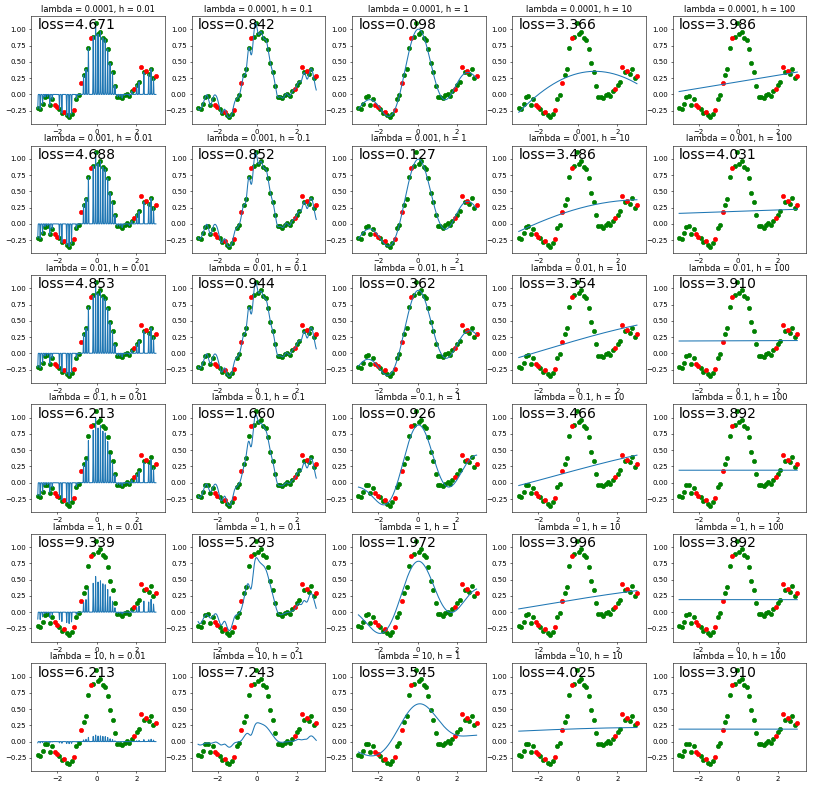

In [5]:
plt.clf()
plt.figure(figsize=(20, 20), dpi=50)

l_cand = [1e-4, 1e-3, 1e-2, 0.1, 1, 10]
h_cand = [0.01, 0.1, 1, 10, 100]

sample_size = 50
batch_size = 10
batch_num = int(sample_size / batch_size)

# create sample
xmin, xmax = -3, 3
x, y = generate_sample(xmin=xmin, xmax=xmax, sample_size=sample_size)
np.random.seed(2)
shuffle = np.random.permutation(sample_size)
x = x[shuffle]
y = y[shuffle]

# cross validation
for i in range(len(l_cand)):
    for j in range(len(h_cand)):
        total_loss = 0
        for k in range(batch_num):
            train_idx = [idx for idx in range(sample_size) if not batch_size*k<=idx<batch_size*(k+1)] 
            test_idx = [idx for idx in range(sample_size) if batch_size*k<=idx<batch_size*(k+1)] 
            x_train = x[train_idx]
            x_test = x[test_idx]
            y_train = y[train_idx]
            y_test = y[test_idx]
            
            x_plot, pred, loss = LSM(l_cand[i], h_cand[j], x_train, x_test, y_train, y_test)
            total_loss += loss
        
        #最後のブロックについて図示
        plt.subplot(len(l_cand), len(h_cand), len(h_cand)*i + j + 1)
        plt.title('lambda = {}, h = {}'.format(l_cand[i], h_cand[j]))
        plt.scatter(x_train, y_train, c='green', marker='o')
        plt.scatter(x_test, y_test, c='red', marker='o')
        plt.text(-3, 1, 'loss={:.3f}'.format(total_loss), size = 20, color = "black")
        plt.plot(x_plot, pred)
            
        print('lambda = {}, h = {}, loss = {}'.format(l_cand[i], h_cand[j], total_loss))
        
plt.savefig('lsr.png')

λを小さくすると曲線の0からの変動が大きくなり，hを小さくすると山の幅が小さくなった．  
ここではλ=1e-4, h=1の時にもっともlossが小さくなったのでこれが最適なパラメータであると言える．  